In [567]:
import numpy as np
from scipy.special import factorial2 as fact2
from scipy.special import hyp1f1 # This is for Boys set-up
from scipy import special
from scipy import linalg
from scipy.linalg import sqrtm

In [568]:
#Build Gaussian basis functions
class gaussian():
    def __init__(self, coordinates=[0,0,0], shell=(0,0,0), exponents=[], coeffs=[]):
        self.coordinates = np.asarray(coordinates)
        self.shell = shell
        self.exponents = exponents
        self.coeffs = coeffs
        self.norm = None
        self.normalize()
    def normalize(self):
        # normalize primitive gaussian functions
        l,m,n = self.shell
        L = l+m+n
        self.norm = np.sqrt(np.power(2, (2*L)+1.5)*np.power(self.exponents,L+1.5) \
                            /fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5)) 
        # normalize contracted gaussian functions
        prefactor = np.power(np.pi, 1.5)*fact2(2*l-1)*fact2(2*m-1)*fact2(2*n-1)/np.power(2.0,L)
        N = 0.0
        n_exponents = len(self.exponents)
        for ia in range(n_exponents):
            for ib in range(n_exponents):
                N += self.norm[ia]*self.norm[ib]*self.coeffs[ia]*self.coeffs[ib]/np.power(self.exponents[ia] + self.exponents[ib],L+1.5)
        N *= prefactor
        N = np.power(N, -0.5)
        for ia in range(n_exponents):
            self.coeffs[ia] *= N

In [569]:
#Based on Hermite Gaussians numerical integration, E is expansion coefficient;
#i,j are angular quantum numbers for two different electrons;
#Q are distance between coordinates of two electrons
def E(i,j,t,Q,a,b):
    p = a + b
    q = a*b/p
    if (t<0) or (t> (i+j)):
        return 0.0
    elif i == j == t == 0:
        return np.exp(-q*Q*Q)
    elif j == 0:
        return (1/(2*p))*E(i-1,j,t-1,Q,a,b)-(q*Q/a)*E(i-1,j,t,Q,a,b)+(t+1)*E(i-1,j,t+1,Q,a,b) #recursive steps
    else:
        return (1/(2*p))*E(i,j-1,t-1,Q,a,b)+(q*Q/b)*E(i,j-1,t,Q,a,b)+(t+1)*E(i,j-1,t+1,Q,a,b) #recursive steps

#lmn1 and lmn2 are two arrays containing orbital angumlar momentum numbers;
#a,b are exponents for gaussian functions;
#A, B are two coordinates for electrons
def overlap(a, lmn1, A, b, lmn2, B):
    l1, m1, n1 = lmn1
    l2, m2, n2 = lmn2
    S1 = E(l1,l2,0,A[0]-B[0],a,b) #x
    S2 = E(m1,m2,0,A[1]-B[1],a,b) #y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) #z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

#Calculation of individual overlap values
#Building up the overlap matrix
def get_ovlp(molecule):
    nbasis = len(molecule)
    Ovlp = np.zeros([nbasis,nbasis])
    def S(a,b):
        s=0
        for ia, ca in enumerate(a.coeffs):
            for ib, cb in enumerate(b.coeffs):
                s += a.norm[ia]*b.norm[ib]*ca*cb*\
                overlap(a.exponents[ia], a.shell, a.coordinates, b.exponents[ib], b.shell, b.coordinates)
        return s
    for i in range(nbasis):
        for j in range(nbasis):               
            Ovlp[i,j] += S(molecule[i],molecule[j])
    return Ovlp        

In [570]:
#Calculation of kinetic matrix, kinetic matrix integrals could be written in terms of overlap integrals
#Its variables are the same as overlap matrix
def kinetic(a, lmn1, A, b, lmn2, B):
    l1,m1,n1 =lmn1
    l2,m2,n2 =lmn2
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) + overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) + overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) + m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) + n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B))
    return term0 + term1 + term2
    
def get_kinetic(molecule):
    nbasis = len(molecule)
    P = np.zeros([nbasis,nbasis])
    def T(a,b):
        t=0
        for ia, ca in enumerate(a.coeffs):
            for ib, cb in enumerate(b.coeffs):
                t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exponents[ia], a.shell, a.coordinates, b.exponents[ib], b.shell, b.coordinates)
        return t
    for i in range(nbasis):
        for j in range(nbasis):                 
            P[i,j] += T(molecule[i],molecule[j])
    return P     

In [571]:
#Calculation of nuclear-electron potential matrix 
#Boys set-up
def boys(n, T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2*n+1)
#Hermite numerical integrals
#PCx,y,z : cartesian vector distance between electron and nuclear center
#RPC: distance between electron and nuclear center
def R(t,u,v,n,p,PCx,PCy,PCz,RPC):       #recursive 
    T = p*RPC*RPC
    val = 0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T)
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
            val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC)
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
            val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC)
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
            val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC)
    return val
#Setup of composite gaussian center coordinate
def gaussian_product_center(a,A,b,B):
    return (a*A+b*B)/(a+b)
#Calculation of individual nuclear attraction
def nuclear_attraction(a, lmn1, A, b, lmn2, B, C=[]):
    l1,m1,n1 =lmn1
    l2,m2,n2 =lmn2
    p = a+b
    P = gaussian_product_center(a,A,b,B)
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                val += E(l1,l2,t,A[0]-B[0],a,b) * \
                       E(m1,m2,u,A[1]-B[1],a,b) * \
                       E(n1,n2,v,A[2]-B[2],a,b) * \
                       R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p
    return val
def get_C(molecule):
    nbasis =len(molecule)
    coordinates = []
    for i in range(nbasis):
        coordinates.append(molecule[i].coordinates)
    coordinates = np.array(coordinates)
    coordinates = np.unique(coordinates, axis=0)
    return coordinates

def get_potential(molecule, Z):
    C = get_C(molecule)                                 # coordinates are positions of all nucleus
    natoms = len(Z)
    nbasis = len(molecule)
    V_ne = np.zeros([nbasis,nbasis])
    def V(a,b,C=[]):
        v = 0.0
        for ia, ca in enumerate(a.coeffs):
            for ib, cb in enumerate(b.coeffs):
                v += a.norm[ia]*b.norm[ib]*ca*cb*\
                     nuclear_attraction(a.exponents[ia],a.shell,a.coordinates,\
                                        b.exponents[ib],b.shell,b.coordinates,C)
        return v
    for atom in range(natoms):
        for i in range(nbasis):
            for j in range(nbasis):
                V_ne[i,j] += -Z[atom]*V(molecule[i], molecule[j], C[atom])
    return V_ne

In [572]:
#electron_repulsion matrix building: that is a two-body problem, and Hermite numerical integral could also be applied;
#Calculation of individual two electron electron repulsions
def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): #<ab|cd> <ac|bd>
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a + b
    q = c + d
    alpha = p*q/(p+q)
    P = gaussian_product_center(a, A, b, B)
    Q= gaussian_product_center(c, C, d, D)
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for t1 in range(l3+l4+1):
                    for u1 in range(m3+m4+1):
                        for v1 in range(n3+n4+1):
                            val +=E(l1,l2,t,A[0]-B[0],a,b) * \
                                  E(m1,m2,u,A[1]-B[1],a,b) * \
                                  E(n1,n2,v,A[2]-B[2],a,b) * \
                                  E(l3,l4,t1,C[0]-D[0],c,d) * \
                                  E(m3,m4,u1,C[1]-D[1],c,d) * \
                                  E(n3,n4,v1,C[2]-D[2],c,d) * \
                                  np.power(-1, t1+u1+v1) *\
                                  R(t+t1,u+u1,v+v1,0,alpha, P[0]-Q[0], P[1]-Q[1], P[2]-Q[2], RPQ)
    val *= 2 * np.power(np.pi, 2.5)/ (p*q*np.sqrt(p+q))
    return val

#Building up the electron_repulsion_matrix
    def get_potential_ee (molecule):
        nbasis = len(molecule)
        V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])
        def ERI(a,b,c,d):
            eri = 0.0
            for ja, ca in enumerate(a.coeffs):
                for jb, cb in enumerate(b.coeffs):
                    for jc, cc in enumerate(c.coeffs):
                        for jd, cd in enumerate(d.coeffs):
                            eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                                   ca*cb*cc*cd*\
                            electron_repulsion(a.exponents[ja],a.shell, a.coordinates, \
                                            b.exponents[jb],b.shell, b.coordinates, \
                                              c.exponents[jc],c.shell, c.coordinates, \
                                              d.exponents[jd],d.shell, d.coordinates)
            return eri
        for i in range(nbasis):
            for j in range(nbasis):
                for k in range(nbasis):
                    for l in range(nbasis):
                        V_ee[i][j][k][l]+= ERI(molecule[i], molecule[j], molecule[k], molecule[l])
        return V_ee


In [573]:
#Calculation of nuclear_nuclear_repulsion_energy
def E_nn(molecule, Z):
    C = get_C(molecule)
    assert (len(C) == len(Z))
    natoms = len(Z)
    E_NN = 0
    for i in range(natoms):
        Zi = Z[i]
        for j in range(natoms):
            if j > i:
                Zj = Z[j]
                Rij = np.linalg.norm(C[i]-C[j])   
                E_NN += (Zi*Zj)/Rij
                
    return E_NN

In [653]:
#Building Fock Matrix. F = Hcore + G
#G = density * (J - 0.5*K)
def compute_G(density_matrix, Vee):
    nbasis_functions = density_matrix.shape[0]
    G = np.zeros((nbasis_functions, nbasis_functions))
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            for k in range(nbasis_functions):
                for l in range(nbasis_functions):
                    density = density_matrix[k,l]
                    J = Vee[i,j,k,l]
                    K = Vee[i,l,k,j]
                    G[i,j] += density*(J-0.5*K)
    return G

def compute_density_matrix(mos):
    nbasis_functions = mos.shape[0]
    density_matrix = np.zeros((nbasis_functions, nbasis_functions))
    occupation = 2.0
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            for oo in range(number_occupied_orbitals):
                C = mos[i, oo]               # it is coefficient matrix. Initial guess will be needed.
                C_dagger = mos[j, oo]
                density_matrix[i,j] += occupation * C * C_dagger 
    return density_matrix

def compute_electronic_energy_expectation_value(density_matrix, T, Vne, G):
    Hcore = T + Vne  
    electronic_energy = 0.0
    nbasis_functions = density_matrix.shape[0]
    for i in range(nbasis_functions):
        for j in range(nbasis_functions):
            electronic_energy += density_matrix[i,j] * (Hcore[i,j] + 0.5*G[i,j])
    return electronic_energy

def scf_cycle(molecular_terms, scf_parameters, molecule):
    S, T, Vne, G = molecular_terms
    tolerance, max_scf_steps = scf_parameters
    electronic_energy = 0.0
    nbasis_functions = len(molecule)
    # Initial guess = No guess. Generally EHT could be used to generate the initial guess density matrix
    density_matrix = np.zeros([nbasis_functions, nbasis_functions]) 
    #SCF cycles
    for scf_step in range(max_scf_steps):
        electronic_energy_old = electronic_energy
        G = compute_G(density_matrix, Vee)
        F = T + Vne + G
        S_inverse = linalg.inv(S)
        S_inverse_sqrt = linalg.sqrtm(S_inverse)
        F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
        eigenvalues, eigenvectors = linalg.eigh(F_unitS)
        mos = np.dot(S_inverse_sqrt, eigenvectors)
        density_matrix = compute_density_matrix(mos)
        electronic_energy = compute_electronic_energy_expectation_value(density_matrix, T, Vne, G)
        if abs(electronic_energy-electronic_energy_old) < tolerance:
            return electronic_energy
    
    print("Warning: Convergence not met")
    return electronic_energy


In [654]:
#Building up hydrogen molecule with sto-3g basis
energies = []
for i in range (4,100):    
    H1_1s = gaussian([0,0,0], (0,0,0), exponents_H1s, coeffs_H1s)
    H2_1s = gaussian([0,0,0.1*i], (0,0,0), exponents_H1s, coeffs_H1s)
    molecule = [H1_1s,H2_1s]
    S = get_ovlp(molecule)
    T = get_kinetic(molecule)
    V = get_potential(molecule,[1,1])
    Vee = get_potential_ee(molecule)
    Enn = E_nn(molecule, [1,1])
    number_occupied_orbitals = 1
    molecular_terms = [S, T, V, Vee]
    scf_parameters = [1e-5, 20]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
    energies.append(total_energy)
    

In [655]:
d = []
for i in range(4,100):
    d.append(0.1*i)

In [737]:
#Building up hydrogen molecule with 6-31g basis
energies_1 = []
H1s_a = [0.1873113696E+02,0.2825394365E+01,0.6401216923E+00]
H1s_a1 =[0.1612777588E+00]
H1s_c = [0.3349460434E-01,0.2347269535E+00,0.8137573261E+00]
H1s_c1 =[1]
for i in range (4,100):    
    H1_1s = gaussian([0,0,0], (0,0,0), H1s_a, H1s_c)
    H1_1s1 = gaussian([0,0,0], (0,0,0), H1s_a1, H1s_c1)
    H2_1s = gaussian([0,0,0.1*i], (0,0,0), H1s_a, H1s_c)
    H2_1s1 = gaussian([0,0,0.1*i], (0,0,0), H1s_a1, H1s_c1)
    molecule = [H1_1s,H1_1s1,H2_1s,H2_1s1]
    S = get_ovlp(molecule)
    T = get_kinetic(molecule)
    V = get_potential(molecule,[1,1])
    Vee = get_potential_ee(molecule)
    Enn = E_nn(molecule, [1,1])
    number_occupied_orbitals = 1
    molecular_terms = [S, T, V, Vee]
    scf_parameters = [1e-5, 50]
    electronic_energy = scf_cycle(molecular_terms, scf_parameters, molecule)
    total_energy = electronic_energy + Enn
    energies_1.append(total_energy)

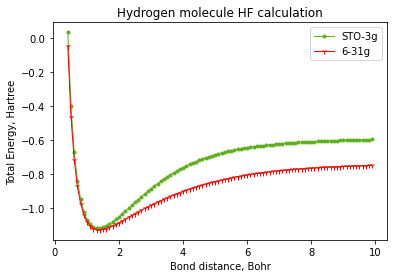

In [751]:
import matplotlib.pyplot as plt
plt.title('Hydrogen molecule HF calculation')
plt.xlabel("Bond distance, Bohr")
plt.ylabel("Total Energy, Hartree")
plt.plot(np.array(d), energies,'#5eb01d',linewidth=1,marker='o',markersize=3,label='STO-3g')
plt.plot(np.array(d), energies_1,'#ff0000',linewidth=1,marker='1',markersize=5,label='6-31g')
plt.legend()

#Building H2O molecule using STO-3g basis
H1s_a = [0.3425250914E+01,0.6239137298E+00,0.1688554040E+00]
H1s_c = [0.1543289673E+00,0.5353281423E+00,0.4446345422E+00]
O1s_a = [0.1307093214E+03,0.2380886605E+02,0.6443608313E+01]
O1s_c = [0.1543289673E+00,0.5353281423E+00,0.4446345422E+00]
O2s_a = [0.5033151319E+01,0.1169596125E+01,0.3803889600E+00]
O2s_c = [-0.9996722919E-01,0.3995128261E+00,0.7001154689E+00]
O2p_a = [0.5033151319E+01,0.1169596125E+01,0.3803889600E+00]
O2p_c = [0.1559162750E+00,0.6076837186E+00,0.3919573931E+00]
H1s = gaussian([0,0.751155,-0.465285], (0,0,0), H1s_a, H1s_c)
H1s_2 = gaussian([0,-0.751155,-0.465285], (0,0,0), H1s_a, H1s_c)
O1s = gaussian([0.000000,0.000000,0.116321], (0,0,0), O1s_a, O1s_c)
O2s = gaussian([0.000000,0.000000,0.116321], (0,0,0), O2s_a, O2s_c)
O2px = gaussian([0.000000,0.000000,0.116321], (1,0,0), O2p_a, O2p_c)
O2py = gaussian([0.000000,0.000000,0.116321], (0,1,0), O2p_a, O2p_c)
O2pz = gaussian([0.000000,0.000000,0.116321], (0,0,1), O2p_a, O2p_c)
molecule = [H1s,O1s,O2s,O2px,O2py,O2pz,H1s_2]